In [216]:
import pandas as pd
from pathlib import Path


In [217]:
csv_files = {
    "machine_5090": "RTX 5090.csv",
    "machine_4090": "RTX 4090.csv",
    "machine_4070": "RTX 4070.csv",
    "machine_5060": "RTX 5060 TI.csv",
}


In [218]:
data = {}

for machine, path in csv_files.items():
    df = pd.read_csv(path)
    df["Machine"] = machine        # tag origin machine
    data[machine] = df


In [219]:
df_all = pd.concat(data.values(), ignore_index=True)

In [220]:
print(df_all["Machine"].value_counts())
print(df_all.columns)

Machine
machine_4090    435
machine_5090    432
machine_4070    432
machine_5060    432
Name: count, dtype: int64
Index(['Model', 'Solver', 'Nodes', 'Elements', 'Total Time', 'Assembly',
       'Solve', 'Iterations', 'Peak RAM', 'Peak VRAM', 'Status', 'Date',
       'Machine'],
      dtype='object')


In [221]:
machine_hardware = {
    "machine_5090": {
        "GPU": "RTX 5090",
        "CPU": "Intel64 Family 6 Model 198",
        "VRAM_GB": 31.8
    },
    "machine_4090": {
        "GPU": "RTX 4090",
        "CPU": "Intel Core i9-13900K",
        "VRAM_GB": 24.0
    },
    "machine_4070": {
        "GPU": "RTX 4070",
        "CPU": "Intel64 Family 6 Model 182",
        "VRAM_GB": 12.0
    },
    "machine_5060": {
        "GPU": "RTX 5060 Ti",
        "CPU": "AMD64 Family 25 Model 27",
        "VRAM_GB": 15.9
    }
}


In [222]:
df_all["GPU"] = df_all["Machine"].map(lambda m: machine_hardware[m]["GPU"])
df_all["CPU"] = df_all["Machine"].map(lambda m: machine_hardware[m]["CPU"])
df_all["VRAM_GB"] = df_all["Machine"].map(lambda m: machine_hardware[m]["VRAM_GB"])


In [223]:
df_all[["Machine", "GPU", "CPU", "VRAM_GB"]].drop_duplicates()



,Machine,GPU,CPU,VRAM_GB
0,machine_5090,RTX 5090,Intel64 Family 6 Model 198,31.8
432,machine_4090,RTX 4090,Intel Core i9-13900K,24.0
867,machine_4070,RTX 4070,Intel64 Family 6 Model 182,12.0
1299,machine_5060,RTX 5060 Ti,AMD64 Family 25 Model 27,15.9


In [224]:
# --- Clean Nodes column (remove non-breaking spaces, cast to int) ---
df_all["Nodes"] = (
    df_all["Nodes"]
    .astype(str)
    .str.replace("\u00a0", "", regex=False)  # remove non-breaking spaces
    .astype(int)
)


In [225]:
df_all["Nodes"].dtype


dtype('int64')

In [226]:
df_all["Total Time_s"] = df_all["Total Time"].apply(parse_time_to_seconds)


In [227]:
sorted(df_all["Solver"].astype(str).unique())


['CPU', 'GPU', 'Multiprocess', 'Numba', 'Numba CUDA', 'Threaded']

In [228]:
SOLVER_ORDER = [
    "CPU",
    "Multiprocess",
    "Threaded",
    "Numba",
    "GPU",
    "Numba CUDA",
]

SOLVER_COLORS = {
    "CPU": "#1f77b4",          # blue
    "Multiprocess": "#ff7f0e", # orange
    "Threaded": "#2ca02c",     # green
    "GPU": "#d62728",          # red
    "Numba": "#9467bd",        # purple
    "Numba CUDA": "#8c564b",   # brown
}


In [229]:
# Fixed machine colors (stable across all figures)
MACHINE_COLORS = {
    "machine_5090": "#1f77b4",  # blue
    "machine_4090": "#ff7f0e",  # orange
    "machine_4070": "#2ca02c",  # green
    "machine_5060": "#d62728",  # red
}

# Line styles per solver
SOLVER_LINESTYLE = {
    "CPU": "-",
    "Threaded": "--",
    "Multiprocess": ":",
    "Numba": "-.",
    "GPU": "-",
    "Numba CUDA": "--",
}


In [230]:
df_all["Solver"] = pd.Categorical(
    df_all["Solver"],
    categories=SOLVER_ORDER,
    ordered=True
)


In [231]:
df_all["Solver"].cat.categories


Index(['CPU', 'Multiprocess', 'Threaded', 'Numba', 'GPU', 'Numba CUDA'], dtype='object')

# Log–log scaling plot: Y-Shaped average performance

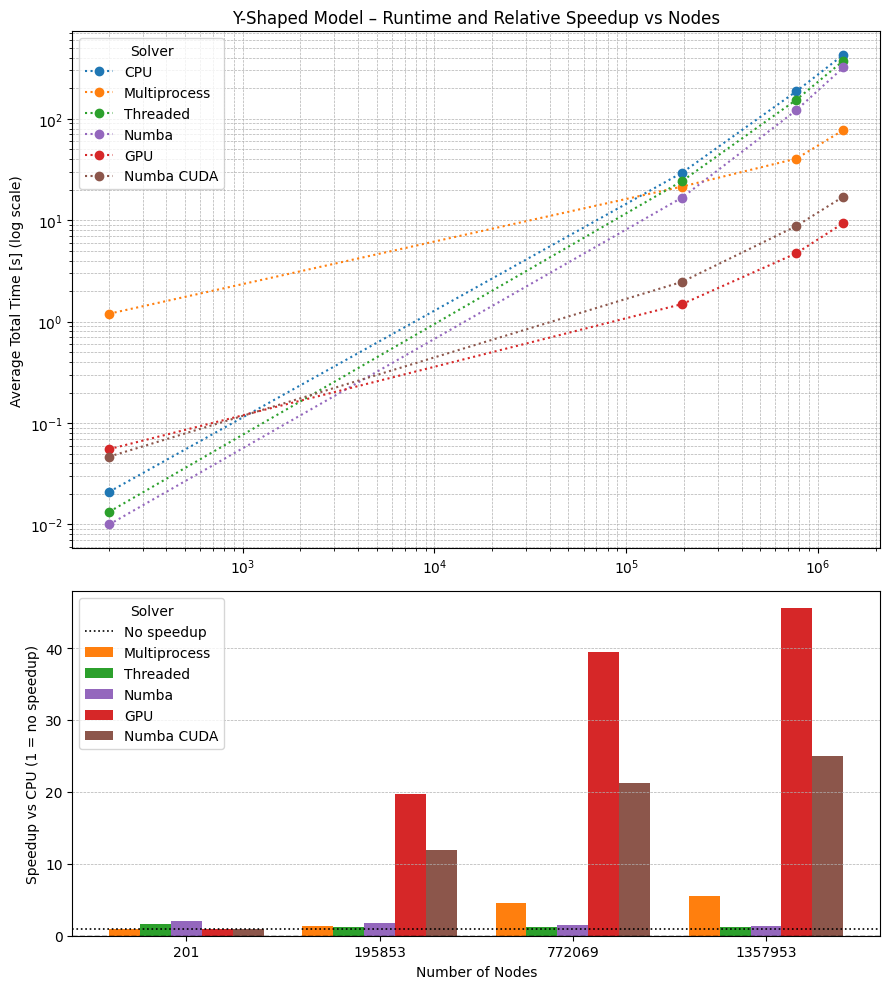

In [232]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Filter to Y-Shaped model
# -------------------------------
df_y = df_all[df_all["Model"] == "Y-Shaped"].copy()

# -------------------------------
# Aggregate average runtime
# -------------------------------
avg_df = (
    df_y
    .groupby(["Solver", "Nodes"], as_index=False, observed=True)["Total Time_s"]
    .mean()
)

# -------------------------------
# CPU baseline
# -------------------------------
CPU_df = avg_df[avg_df["Solver"] == "CPU"][["Nodes", "Total Time_s"]]
CPU_df = CPU_df.rename(columns={"Total Time_s": "CPU_Time_s"})

speedup_df = avg_df.merge(CPU_df, on="Nodes")
speedup_df = speedup_df[speedup_df["Solver"] != "CPU"]

speedup_df["Speedup"] = (
    speedup_df["CPU_Time_s"] / speedup_df["Total Time_s"]
)

# Clamp: no speedup shown as 1
speedup_df["Speedup"] = speedup_df["Speedup"].clip(lower=1.0)

# -------------------------------
# Figure layout
# -------------------------------
fig = plt.figure(figsize=(9, 10))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 2])

ax_top = fig.add_subplot(gs[0])
ax_bottom = fig.add_subplot(gs[1])

# ===============================
# TOP: Runtime (log–log)
# ===============================
for solver in SOLVER_ORDER:
    g = avg_df[avg_df["Solver"] == solver]
    if g.empty:
        continue

    g = g.sort_values("Nodes")

    ax_top.plot(
        g["Nodes"],
        g["Total Time_s"],
        marker="o",
        linestyle=":",
        label=solver,
        color=SOLVER_COLORS[solver],
    )

ax_top.set_xscale("log")
ax_top.set_yscale("log")
ax_top.set_ylabel("Average Total Time [s] (log scale)")
ax_top.set_title("Y-Shaped Model – Runtime and Relative Speedup vs Nodes")
ax_top.grid(True, which="both", linestyle="--", linewidth=0.5)
ax_top.legend(title="Solver")

# ===============================
# BOTTOM: Signed speedup (bars)
# ===============================
nodes = np.sort(speedup_df["Nodes"].unique())
solvers = [s for s in SOLVER_ORDER if s != "CPU" and s in speedup_df["Solver"].unique()]

x = np.arange(len(nodes))
bar_width = 0.8 / len(solvers)

for i, solver in enumerate(solvers):
    g = (
        speedup_df[speedup_df["Solver"] == solver]
        .set_index("Nodes")
        .reindex(nodes)
    )

    ax_bottom.bar(
        x + i * bar_width,
        g["Speedup"],
        width=bar_width,
        label=solver,
        color=SOLVER_COLORS[solver],
    )

# Reference line: CPU baseline
ax_bottom.axhline(0.0, color="black", linewidth=1.0, linestyle="--")

ax_bottom.set_xticks(x + bar_width * (len(solvers) - 1) / 2)
ax_bottom.set_xticklabels(nodes)
ax_bottom.set_xlabel("Number of Nodes")
ax_bottom.set_ylabel("Relative Speedup vs CPU")
ax_bottom.grid(True, axis="y", linestyle="--", linewidth=0.5)
ax_bottom.axhline(
    1.0,
    linestyle=":",
    linewidth=1.2,
    color="black",
    label="No speedup"
)
ax_bottom.set_ylabel("Speedup vs CPU (1 = no speedup)")

ax_bottom.legend(title="Solver")

plt.tight_layout()
fig.savefig(
    "y_shaped_runtime_speedup.svg",
    format="svg",
    bbox_inches="tight"
)

plt.show()


# Y-Shaped — GPU runtime vs nodes (per machine)

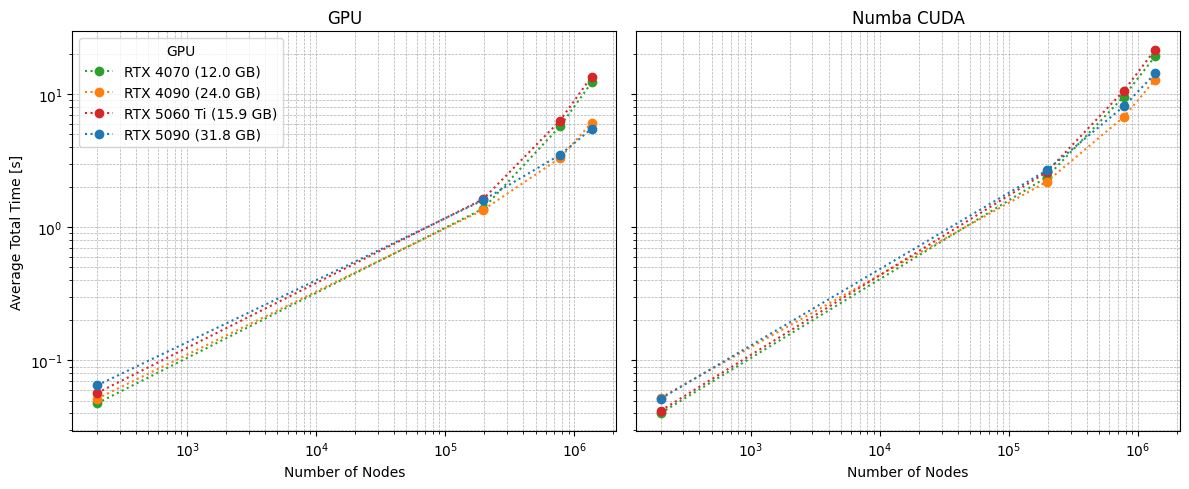

In [233]:
import matplotlib.pyplot as plt

GPU_SOLVERS = ["GPU", "Numba CUDA"]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, solver in zip(axes, GPU_SOLVERS):

    df_sub = df_all[
        (df_all["Model"] == "Y-Shaped") &
        (df_all["Solver"] == solver)
    ]

    avg_df = (
        df_sub
        .groupby(
            ["Machine", "GPU", "VRAM_GB", "Nodes"],
            as_index=False,
            observed=True
        )["Total Time_s"]
        .mean()
    )

    for (machine, GPU, vram), g in avg_df.groupby(
        ["Machine", "GPU", "VRAM_GB"], sort=False
    ):
        g = g.sort_values("Nodes")

        label = f"{GPU} ({vram:.1f} GB)"

        ax.plot(
            g["Nodes"],
            g["Total Time_s"],
            marker="o",
            linestyle=":",
            color=MACHINE_COLORS[machine],
            label=label,
        )

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(solver)
    ax.set_xlabel("Number of Nodes")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

axes[0].set_ylabel("Average Total Time [s]")
axes[0].legend(title="GPU")

plt.tight_layout()

fig.savefig(
    "y_shaped_GPU_side_by_side.svg",
    format="svg",
    bbox_inches="tight",
    dpi=300
)

plt.show()


# Y-Shaped — CPU runtime vs nodes (per machine)

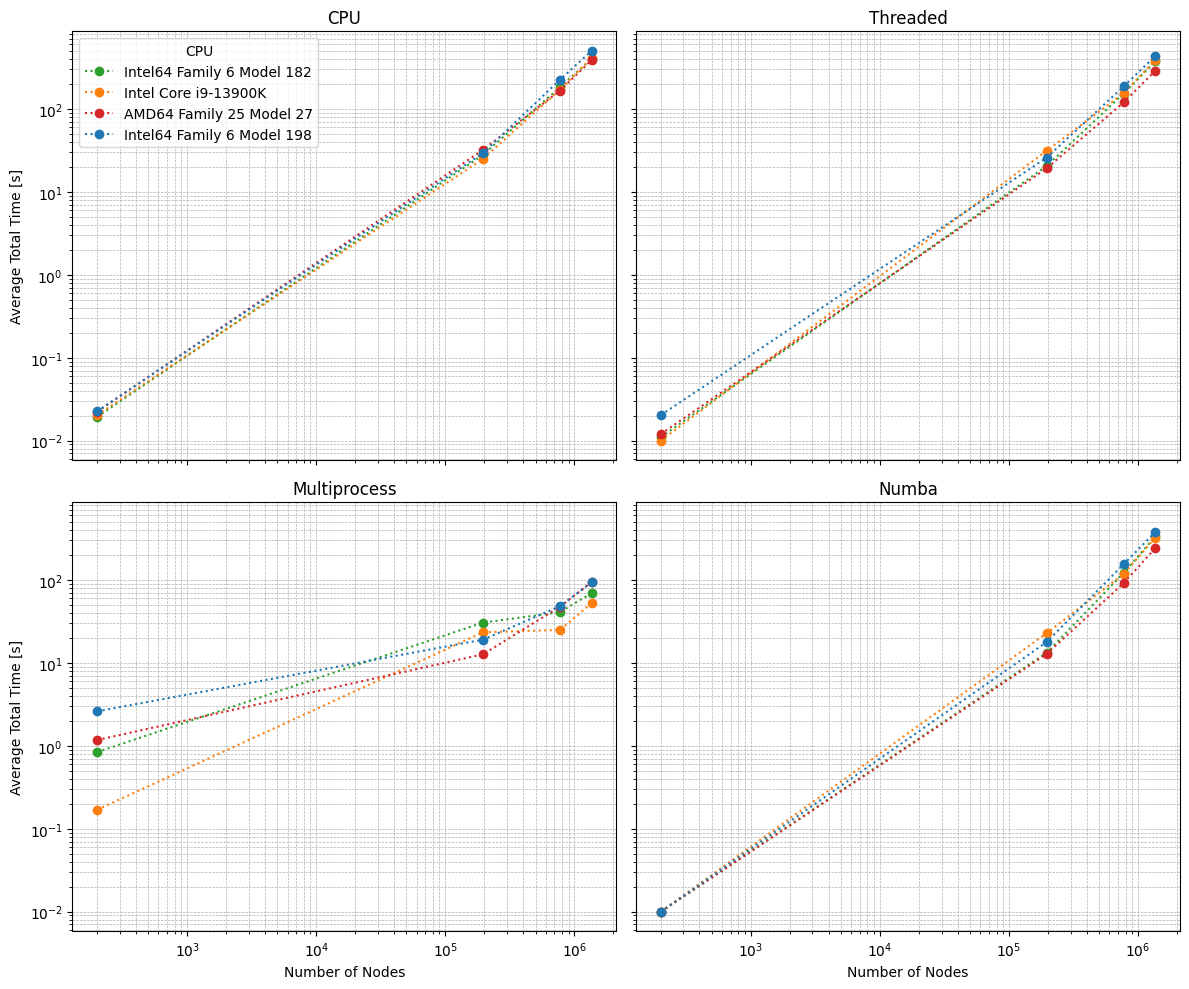

In [234]:
import matplotlib.pyplot as plt

CPU_SOLVERS = ["CPU", "Threaded", "Multiprocess", "Numba"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.flatten()

for ax, solver in zip(axes, CPU_SOLVERS):

    df_sub = df_all[
        (df_all["Model"] == "Y-Shaped") &
        (df_all["Solver"] == solver)
    ]

    avg_df = (
        df_sub
        .groupby(
            ["Machine", "CPU", "Nodes"],
            as_index=False,
            observed=True
        )["Total Time_s"]
        .mean()
    )

    for (machine, CPU), g in avg_df.groupby(
        ["Machine", "CPU"], sort=False
    ):
        g = g.sort_values("Nodes")

        ax.plot(
            g["Nodes"],
            g["Total Time_s"],
            marker="o",
            linestyle=":",
            color=MACHINE_COLORS[machine],
            label=CPU,
        )

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(solver)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# Axis labels
for ax in axes[2:]:
    ax.set_xlabel("Number of Nodes")

for ax in axes[::2]:
    ax.set_ylabel("Average Total Time [s]")

# Legend only once, CPU models only
axes[0].legend(title="CPU")

plt.tight_layout()

fig.savefig(
    "y_shaped_CPU_2x2_execution_models.svg",
    format="svg",
    bbox_inches="tight",
    dpi=300
)

plt.show()


# Scatter plot: average runtime per geometry

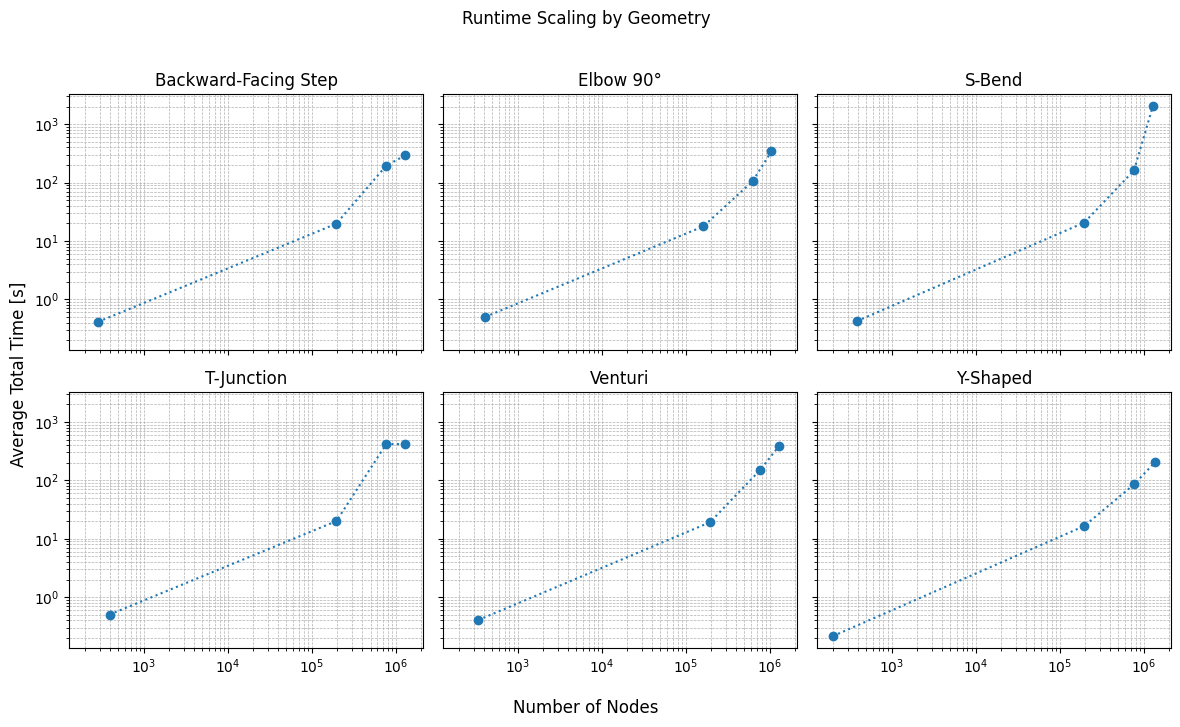

In [235]:
import matplotlib.pyplot as plt
import math

# -------------------------------
# Aggregate: average per geometry per node count
# -------------------------------
avg_df = (
    df_all
    .groupby(["Model", "Nodes"], as_index=False, observed=True)["Total Time_s"]
    .mean()
)

models = avg_df["Model"].unique()
n_models = len(models)

# -------------------------------
# Layout: square-ish grid
# -------------------------------
n_cols = math.ceil(math.sqrt(n_models))
n_rows = math.ceil(n_models / n_cols)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(4 * n_cols, 3.5 * n_rows),
    sharex=True,
    sharey=True
)

axes = axes.flatten()

# -------------------------------
# Plot each geometry
# -------------------------------
for ax, model in zip(axes, models):

    g = avg_df[avg_df["Model"] == model].sort_values("Nodes")

    ax.plot(
        g["Nodes"],
        g["Total Time_s"],
        marker="o",
        linestyle=":",
    )

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(model)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# -------------------------------
# Remove unused axes
# -------------------------------
for ax in axes[len(models):]:
    ax.axis("off")

# -------------------------------
# Shared labels
# -------------------------------
fig.supxlabel("Number of Nodes")
fig.supylabel("Average Total Time [s]")
fig.suptitle("Runtime Scaling by Geometry", y=1.02)

plt.tight_layout()

# -------------------------------
# Save (always)
# -------------------------------
fig.savefig(
    "geometry_small_multiples_runtime_scaling.svg",
    format="svg",
    bbox_inches="tight",
    dpi=300
)

plt.show()


# Time per node vs number of nodes

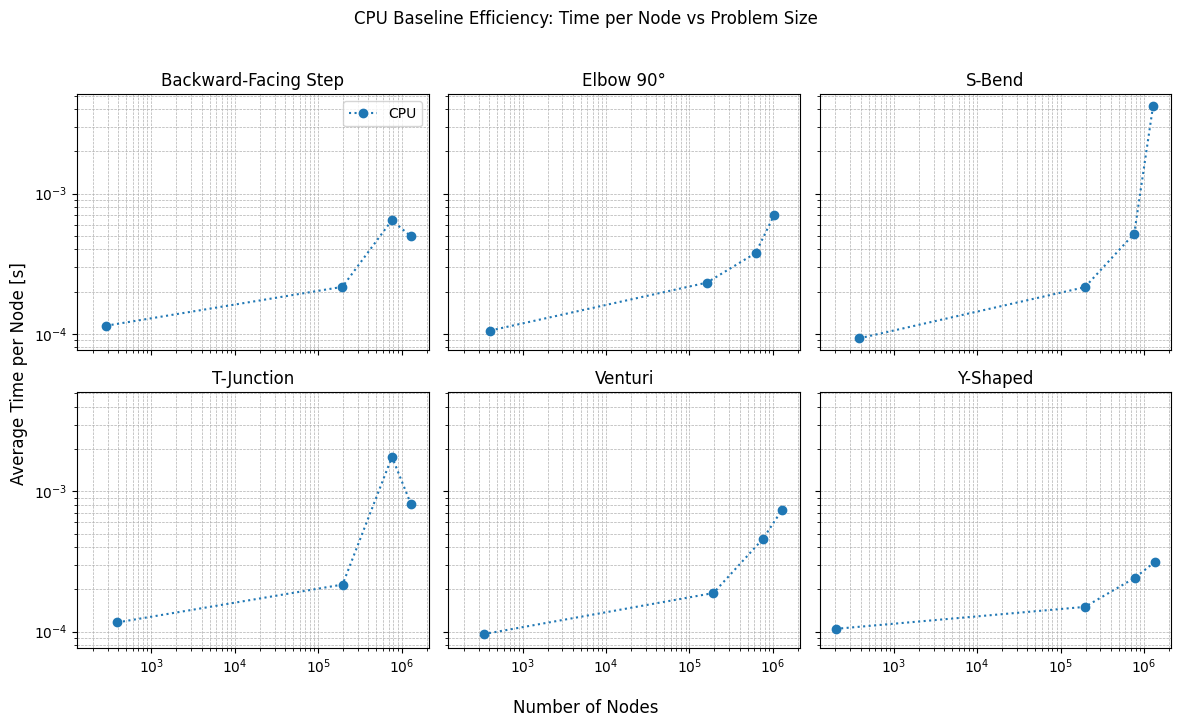

In [236]:
import matplotlib.pyplot as plt
import math
import numpy as np

# -------------------------------
# Filter: CPU baseline only
# -------------------------------
df_CPU = df_all[
    (df_all["Solver"] == "CPU")
].copy()

# -------------------------------
# Aggregate and normalize
# -------------------------------
avg_df = (
    df_CPU
    .groupby(["Model", "Nodes"], as_index=False, observed=True)["Total Time_s"]
    .mean()
)

avg_df["Time_per_Node_s"] = avg_df["Total Time_s"] / avg_df["Nodes"]

models = avg_df["Model"].unique()
n_models = len(models)

# -------------------------------
# Layout: small multiples
# -------------------------------
n_cols = math.ceil(math.sqrt(n_models))
n_rows = math.ceil(n_models / n_cols)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(4 * n_cols, 3.5 * n_rows),
    sharex=True,
    sharey=True
)

axes = axes.flatten()

# -------------------------------
# Plot
# -------------------------------
for ax, model in zip(axes, models):

    g = avg_df[avg_df["Model"] == model].sort_values("Nodes")

    ax.plot(
        g["Nodes"],
        g["Time_per_Node_s"],
        marker="o",
        linestyle=":",
        label="CPU"
    )


    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(model)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# -------------------------------
# Remove unused axes
# -------------------------------
for ax in axes[len(models):]:
    ax.axis("off")

# -------------------------------
# Shared labels
# -------------------------------
fig.supxlabel("Number of Nodes")
fig.supylabel("Average Time per Node [s]")
fig.suptitle(
    "CPU Baseline Efficiency: Time per Node vs Problem Size",
    y=1.02
)

# Legend once
axes[0].legend()

plt.tight_layout()

# -------------------------------
# Save (always)
# -------------------------------
fig.savefig(
    "CPU_time_per_node_vs_nodes_o1.svg",
    format="svg",
    bbox_inches="tight",
    dpi=300
)

plt.show()


# Solver comparison at fixed problem size

C:\Users\user\AppData\Local\Temp\ipykernel_1120\1469001185.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Solver")["Nodes"]


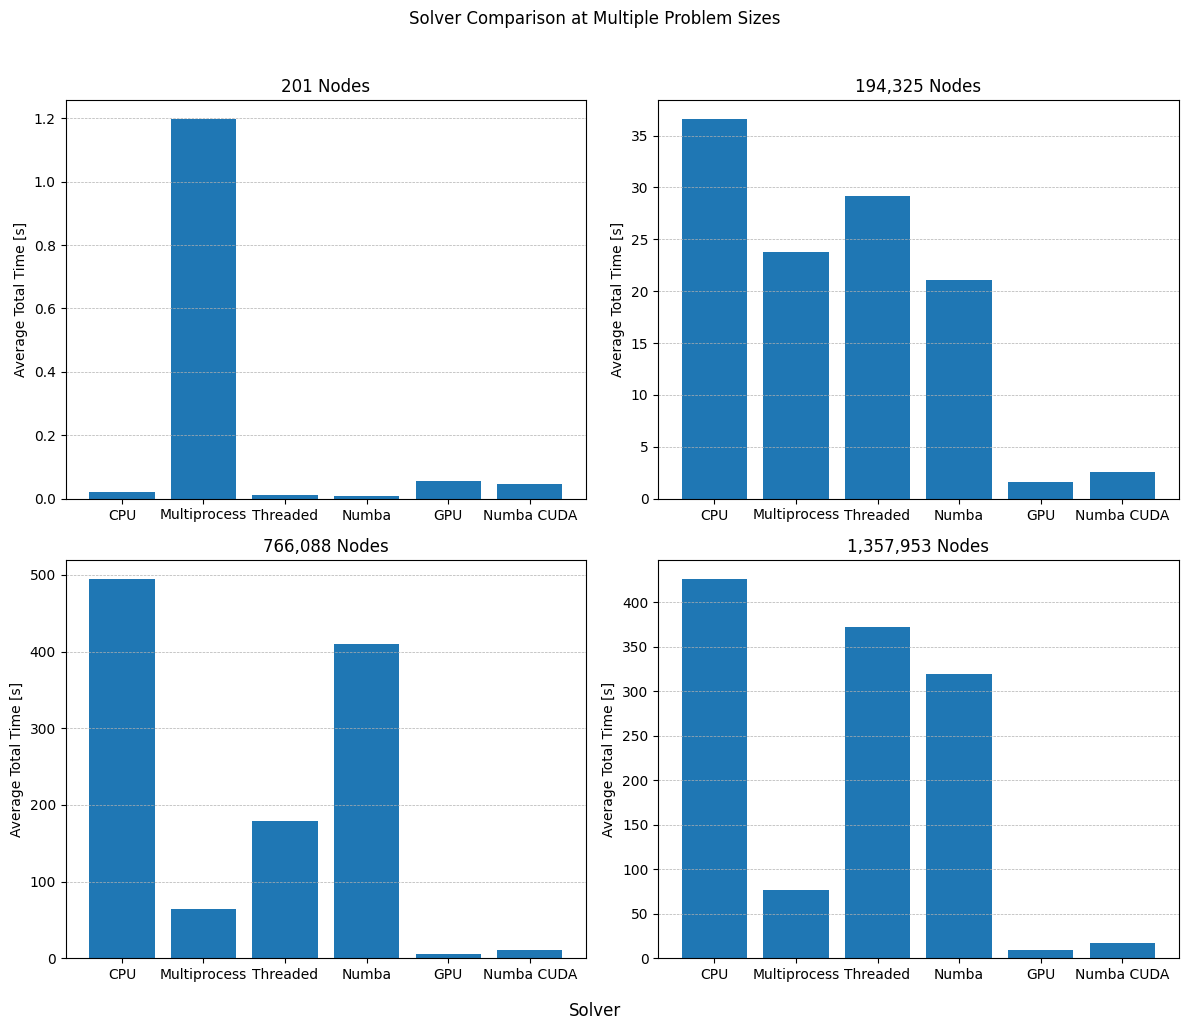

In [237]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# -------------------------------
# Find common node counts
# -------------------------------
solver_nodes = (
    df_all
    .groupby("Solver")["Nodes"]
    .unique()
)

common_nodes = set(solver_nodes.iloc[0])
for nodes in solver_nodes.iloc[1:]:
    common_nodes &= set(nodes)

if len(common_nodes) < 4:
    raise ValueError("Not enough common node counts for a 2x2 plot.")

common_nodes = sorted(common_nodes)

# Select 4 representative node counts
idx = np.linspace(0, len(common_nodes) - 1, 4, dtype=int)
selected_nodes = [common_nodes[i] for i in idx]

# -------------------------------
# Prepare figure (independent y-axes)
# -------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# -------------------------------
# Plot each node count
# -------------------------------
for ax, nodes in zip(axes, selected_nodes):

    df_fixed = df_all[df_all["Nodes"] == nodes]

    avg_df = (
        df_fixed
        .groupby("Solver", as_index=False, observed=True)["Total Time_s"]
        .mean()
    )

    # Enforce solver order
    avg_df["Solver"] = pd.Categorical(
        avg_df["Solver"],
        categories=SOLVER_ORDER,
        ordered=True
    )
    avg_df = avg_df.sort_values("Solver")

    ax.bar(
        avg_df["Solver"],
        avg_df["Total Time_s"]
    )

    ax.set_title(f"{nodes:,} Nodes")
    ax.set_ylabel("Average Total Time [s]")
    ax.grid(True, axis="y", linestyle="--", linewidth=0.5)

# -------------------------------
# Shared x-label
# -------------------------------
fig.supxlabel("Solver")
fig.suptitle("Solver Comparison at Multiple Problem Sizes", y=1.02)

plt.tight_layout()

# -------------------------------
# Save (always)
# -------------------------------
fig.savefig(
    "solver_comparison_2x2_linear_scale.svg",
    format="svg",
    bbox_inches="tight",
    dpi=300
)

plt.show()


# GPU vs CPU crossover point

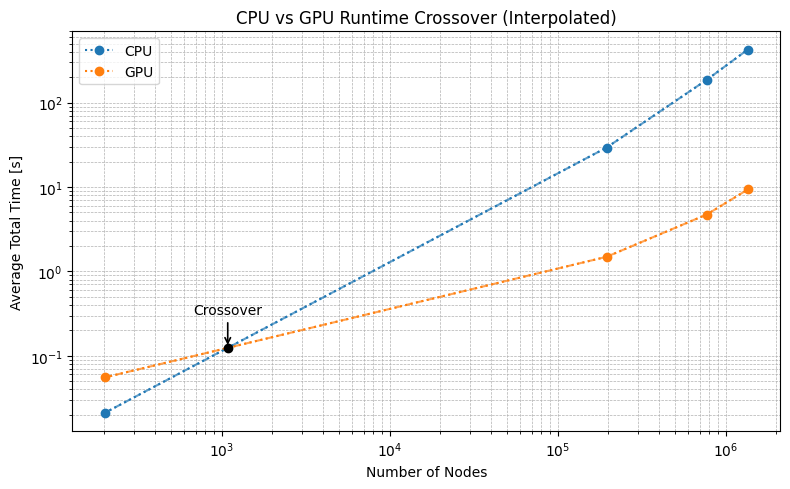

In [238]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import brentq

# -------------------------------
# Filter: Y-Shaped, CPU and GPU
# -------------------------------
df_sub = df_all[
    (df_all["Model"] == "Y-Shaped") &
    (df_all["Solver"].isin(["CPU", "GPU"]))
].copy()

# -------------------------------
# Aggregate average runtime
# -------------------------------
avg_df = (
    df_sub
    .groupby(["Solver", "Nodes"], as_index=False, observed=True)["Total Time_s"]
    .mean()
)

CPU_df = avg_df[avg_df["Solver"] == "CPU"].sort_values("Nodes")
GPU_df = avg_df[avg_df["Solver"] == "GPU"].sort_values("Nodes")

# Align on common node counts
common_nodes = np.intersect1d(CPU_df["Nodes"], GPU_df["Nodes"])
CPU_df = CPU_df[CPU_df["Nodes"].isin(common_nodes)]
GPU_df = GPU_df[GPU_df["Nodes"].isin(common_nodes)]

# -------------------------------
# Log–log interpolation
# -------------------------------
log_nodes = np.log(CPU_df["Nodes"].values)

CPU_interp = interp1d(
    log_nodes,
    np.log(CPU_df["Total Time_s"].values),
    kind="linear",
    fill_value="extrapolate"
)

GPU_interp = interp1d(
    log_nodes,
    np.log(GPU_df["Total Time_s"].values),
    kind="linear",
    fill_value="extrapolate"
)

def diff(log_n):
    return CPU_interp(log_n) - GPU_interp(log_n)

# -------------------------------
# Find crossover (intersection)
# -------------------------------
log_n_min, log_n_max = log_nodes.min(), log_nodes.max()

try:
    crossover_log_n = brentq(diff, log_n_min, log_n_max)
    crossover_nodes = np.exp(crossover_log_n)
    crossover_time = np.exp(CPU_interp(crossover_log_n))
except ValueError:
    crossover_nodes = None
    crossover_time = None

# -------------------------------
# Plot
# -------------------------------
fig, ax = plt.subplots(figsize=(8, 5))

# Base curves
CPU_line, = ax.plot(
    CPU_df["Nodes"],
    CPU_df["Total Time_s"],
    marker="o",
    linestyle=":",
    label="CPU"
)

GPU_line, = ax.plot(
    GPU_df["Nodes"],
    GPU_df["Total Time_s"],
    marker="o",
    linestyle=":",
    label="GPU"
)

# Interpolated curves (same color, no legend)
nodes_dense = np.logspace(
    np.log10(common_nodes.min()),
    np.log10(common_nodes.max()),
    300
)

ax.plot(
    nodes_dense,
    np.exp(CPU_interp(np.log(nodes_dense))),
    linestyle="--",
    color=CPU_line.get_color(),
    alpha=0.7
)

ax.plot(
    nodes_dense,
    np.exp(GPU_interp(np.log(nodes_dense))),
    linestyle="--",
    color=GPU_line.get_color(),
    alpha=0.7
)

# Crossover annotation (arrow UP)
if crossover_nodes is not None:
    ax.scatter(
        crossover_nodes,
        crossover_time,
        color="black",
        zorder=5
    )

    ax.annotate(
        "Crossover",
        xy=(crossover_nodes, crossover_time),
        xytext=(crossover_nodes, crossover_time * 2.5),
        textcoords="data",
        ha="center",
        arrowprops=dict(arrowstyle="->", linewidth=1.2),
    )

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Number of Nodes")
ax.set_ylabel("Average Total Time [s]")
ax.set_title("CPU vs GPU Runtime Crossover (Interpolated)")

ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.legend()

plt.tight_layout()

# -------------------------------
# Save (always)
# -------------------------------
fig.savefig(
    "CPU_GPU_runtime_crossover_interpolated.svg",
    format="svg",
    bbox_inches="tight",
    dpi=300
)

plt.show()


# Assembly vs Solve time breakdown

In [239]:
# Create numeric Assembly and Solve time columns (seconds)
df_all["Assembly_s"] = df_all["Assembly"].apply(parse_time_to_seconds)
df_all["Solve_s"] = df_all["Solve"].apply(parse_time_to_seconds)


In [240]:
df_all[["Assembly", "Assembly_s", "Solve", "Solve_s"]].head(10)


,Assembly,Assembly_s,Solve,Solve_s
0,<0.01s,0.01,3.35s,3.350
1,<0.01s,0.01,3.35s,3.350
2,<0.01s,0.01,3.34s,3.340
3,<0.01s,0.01,2.21s,2.210
4,<0.01s,0.01,2.23s,2.230
5,<0.01s,0.01,2.22s,2.220
6,<0.01s,0.01,1.04s,1.040
7,<0.01s,0.01,1.04s,1.040
8,<0.01s,0.01,1.04s,1.040
9,<0.01s,0.01,45ms,0.045


C:\Users\user\AppData\Local\Temp\ipykernel_1120\1420487002.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Solver")["Nodes"]


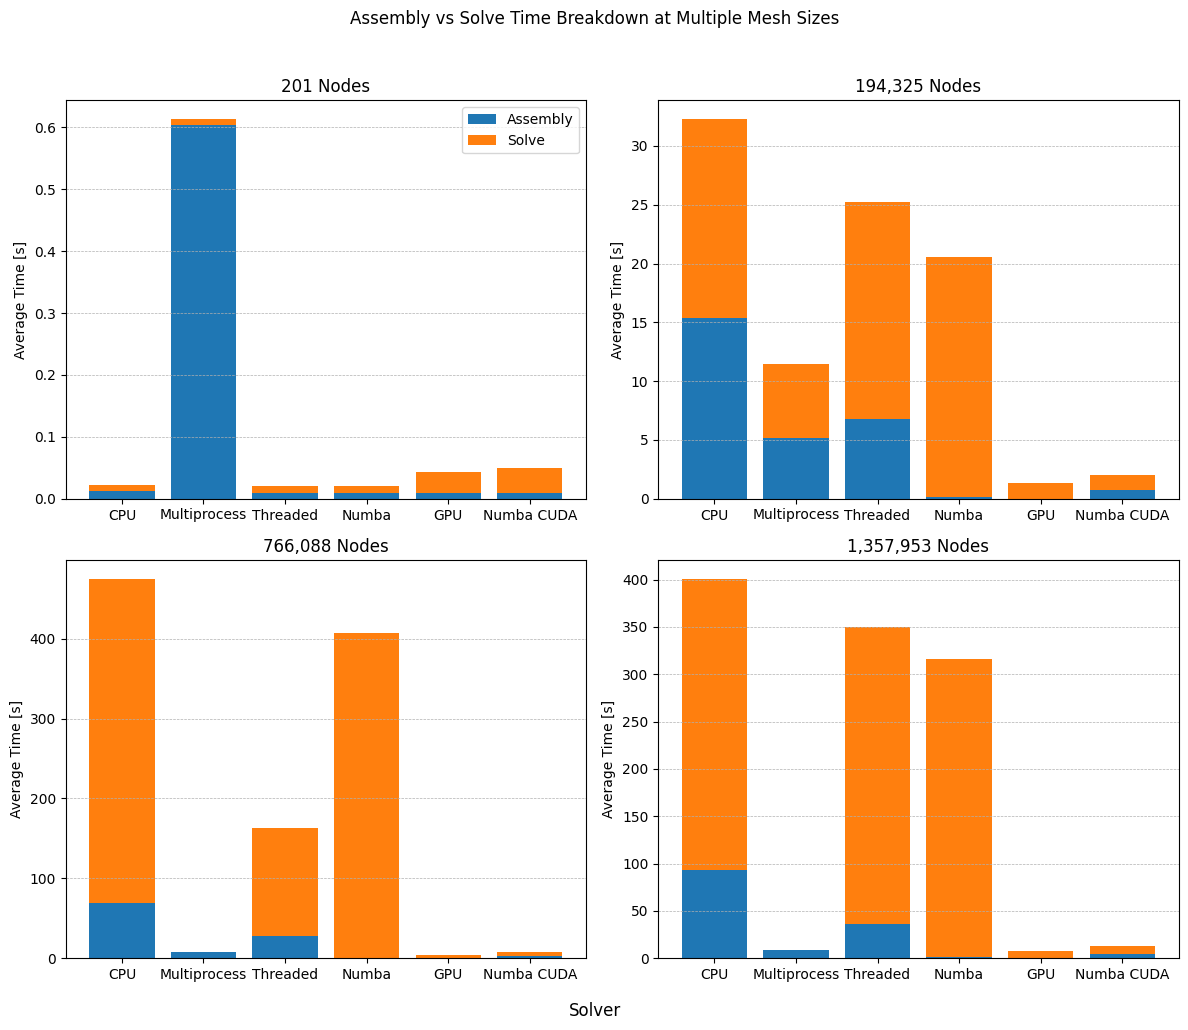

In [241]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# -------------------------------
# Ensure required columns exist
# -------------------------------
required_cols = ["Assembly_s", "Solve_s", "Nodes", "Solver"]
missing = [c for c in required_cols if c not in df_all.columns]
if missing:
    raise KeyError(f"Missing required columns: {missing}")

# -------------------------------
# Find common node counts
# -------------------------------
solver_nodes = (
    df_all
    .groupby("Solver")["Nodes"]
    .unique()
)

common_nodes = set(solver_nodes.iloc[0])
for nodes in solver_nodes.iloc[1:]:
    common_nodes &= set(nodes)

if len(common_nodes) < 4:
    raise ValueError("Not enough common node counts for a 2x2 plot.")

common_nodes = sorted(common_nodes)

# Select 4 representative mesh sizes
idx = np.linspace(0, len(common_nodes) - 1, 4, dtype=int)
selected_nodes = [common_nodes[i] for i in idx]

# -------------------------------
# Prepare figure (independent y-axes)
# -------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# -------------------------------
# Plot per mesh size
# -------------------------------
for ax, nodes in zip(axes, selected_nodes):

    df_fixed = df_all[df_all["Nodes"] == nodes]

    avg_df = (
        df_fixed
        .groupby("Solver", as_index=False, observed=True)[
            ["Assembly_s", "Solve_s"]
        ]
        .mean()
    )

    # Enforce solver order
    avg_df["Solver"] = pd.Categorical(
        avg_df["Solver"],
        categories=SOLVER_ORDER,
        ordered=True
    )
    avg_df = avg_df.sort_values("Solver")

    ax.bar(
        avg_df["Solver"],
        avg_df["Assembly_s"],
        label="Assembly"
    )

    ax.bar(
        avg_df["Solver"],
        avg_df["Solve_s"],
        bottom=avg_df["Assembly_s"],
        label="Solve"
    )

    ax.set_title(f"{nodes:,} Nodes")
    ax.set_ylabel("Average Time [s]")
    ax.grid(True, axis="y", linestyle="--", linewidth=0.5)

# -------------------------------
# Shared labels and legend
# -------------------------------
fig.supxlabel("Solver")
fig.suptitle("Assembly vs Solve Time Breakdown at Multiple Mesh Sizes", y=1.02)

# Legend only once
axes[0].legend()

plt.tight_layout()

# -------------------------------
# Save (always)
# -------------------------------
fig.savefig(
    "assembly_vs_solve_breakdown_2x2_mesh_sizes.svg",
    format="svg",
    bbox_inches="tight",
    dpi=300
)

plt.show()


# Iterations vs number of nodes

In [242]:
# Ensure Iterations is numeric
df_all["Iterations"] = (
    df_all["Iterations"]
    .astype(str)
    .str.replace(r"[^\d]", "", regex=True)  # keep digits only
    .replace("", np.nan)
    .astype(float)
)

# Drop invalid iteration entries
df_all = df_all.dropna(subset=["Iterations"])


In [243]:
df_all["Iterations"].describe()


count      1731.000000
mean       9314.878105
std       26890.664387
min           0.000000
25%         137.000000
50%        4319.000000
75%        9871.000000
max      366133.000000
Name: Iterations, dtype: float64

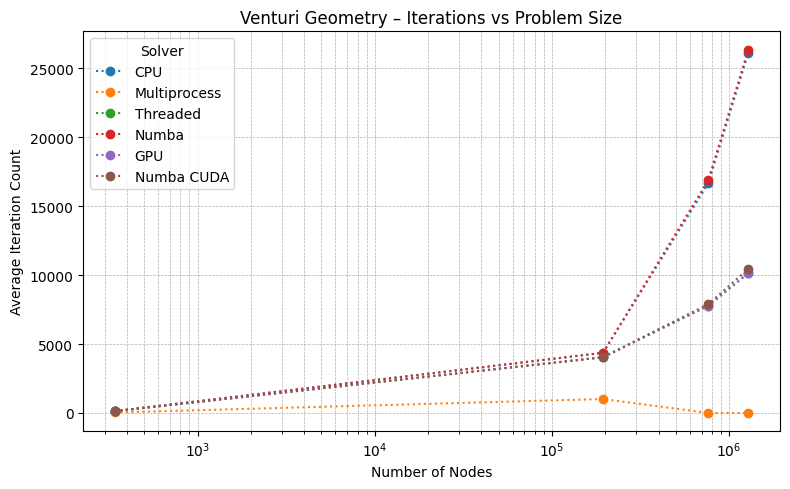

In [244]:
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------------
# Filter: Venturi geometry only
# -------------------------------
df_sub = df_all[
    df_all["Model"].str.lower() == "venturi"
].copy()

# -------------------------------
# Aggregate: average iterations per solver and node count
# -------------------------------
avg_df = (
    df_sub
    .groupby(["Solver", "Nodes"], as_index=False, observed=True)["Iterations"]
    .mean()
)

# Enforce solver order
avg_df["Solver"] = pd.Categorical(
    avg_df["Solver"],
    categories=SOLVER_ORDER,
    ordered=True
)
avg_df = avg_df.sort_values(["Solver", "Nodes"])

# -------------------------------
# Plot
# -------------------------------
fig, ax = plt.subplots(figsize=(8, 5))

for solver in SOLVER_ORDER:
    g = avg_df[avg_df["Solver"] == solver]

    if g.empty:
        continue

    ax.plot(
        g["Nodes"],
        g["Iterations"],
        marker="o",
        linestyle=":",
        label=solver
    )

ax.set_xscale("log")
ax.set_xlabel("Number of Nodes")
ax.set_ylabel("Average Iteration Count")
ax.set_title("Venturi Geometry – Iterations vs Problem Size")

ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.legend(title="Solver")

plt.tight_layout()

# -------------------------------
# Save (always)
# -------------------------------
fig.savefig(
    "venturi_iterations_vs_nodes_all_solvers.svg",
    format="svg",
    bbox_inches="tight",
    dpi=300
)

plt.show()


# Performance envelope (min–max runtime vs problem size)

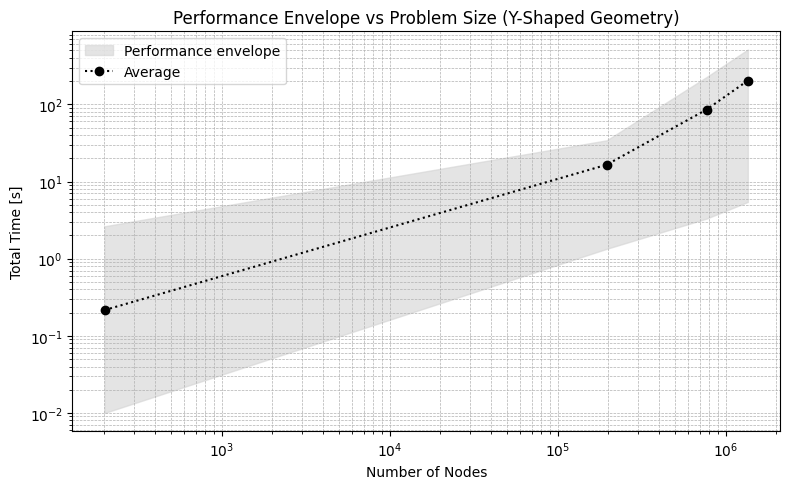

In [245]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Filter: Y-Shaped geometry only
# -------------------------------
df_sub = df_all[
    df_all["Model"] == "Y-Shaped"
].copy()

# -------------------------------
# Aggregate min / max / mean per node count
# -------------------------------
env_df = (
    df_sub
    .groupby("Nodes", as_index=False, observed=True)["Total Time_s"]
    .agg(
        min_time="min",
        max_time="max",
        mean_time="mean"
    )
    .sort_values("Nodes")
)

# -------------------------------
# Plot
# -------------------------------
fig, ax = plt.subplots(figsize=(8, 5))

# Envelope
ax.fill_between(
    env_df["Nodes"],
    env_df["min_time"],
    env_df["max_time"],
    color="lightgray",
    alpha=0.6,
    label="Performance envelope"
)

# Mean line
ax.plot(
    env_df["Nodes"],
    env_df["mean_time"],
    marker="o",
    linestyle=":",
    color="black",
    label="Average"
)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Number of Nodes")
ax.set_ylabel("Total Time [s]")
ax.set_title("Performance Envelope vs Problem Size (Y-Shaped Geometry)")

ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.legend()

plt.tight_layout()

# -------------------------------
# Save (always)
# -------------------------------
fig.savefig(
    "performance_envelope_y_shaped.svg",
    format="svg",
    bbox_inches="tight",
    dpi=300
)

plt.show()


# Normalized runtime per element

In [246]:
import matplotlib.pyplot as plt
import pandas as pd

GEOMETRY = "Venturi"   # <-- change if needed

# -------------------------------
# Filter: one geometry only
# -------------------------------
df_sub = df_all[
    (df_all["Model"] == GEOMETRY) &
    (df_all["Elements"].notna())
].copy()

# -------------------------------
# Aggregate and normalize
# -------------------------------
avg_df = (
    df_sub
    .groupby(["Solver", "Elements"], as_index=False, observed=True)["Total Time_s"]
    .mean()
)

avg_df["Time_per_Element_s"] = avg_df["Total Time_s"] / avg_df["Elements"]

# Enforce solver order
avg_df["Solver"] = pd.Categorical(
    avg_df["Solver"], categories=SOLVER_ORDER, ordered=True
)
avg_df = avg_df.sort_values(["Solver", "Elements"])

# -------------------------------
# Plot
# -------------------------------
fig, ax = plt.subplots(figsize=(8, 5))

for solver in SOLVER_ORDER:
    g = avg_df[avg_df["Solver"] == solver]
    if g.empty:
        continue

    ax.plot(
        g["Elements"],
        g["Time_per_Element_s"],
        marker="o",
        linestyle=":",
        label=solver
    )

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of Elements")
ax.set_ylabel("Time per Element [s]")
ax.set_title(f"{GEOMETRY} – Normalized Runtime per Element")

ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.legend()

plt.tight_layout()
fig.savefig(
    f"normalized_time_per_element_{GEOMETRY.lower()}.svg",
    bbox_inches="tight",
    dpi=300
)
plt.show()


TypeError: unsupported operand type(s) for /: 'float' and 'str'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# USER CONTROL: label angles (degrees)
# -------------------------------
LABEL_ANGLES = {
    "CPU": -90,
    "Multiprocess": 0,
    "Threaded": -90,
    "GPU": 90,
    "Numba": -90,
    "Numba CUDA": 0,
}

DEFAULT_ANGLE = 0  # used if solver not listed

# -------------------------------
# Aggregate averages per solver
# -------------------------------
avg_df = (
    df_all
    .groupby("Solver", as_index=False, observed=True)[
        ["Total Time_s", "Iterations"]
    ]
    .mean()
)

# -------------------------------
# Identify Pareto frontier
# -------------------------------
points = avg_df[["Iterations", "Total Time_s"]].values

is_pareto = np.ones(len(points), dtype=bool)
for i, p in enumerate(points):
    for j, q in enumerate(points):
        if j != i:
            if (q[0] <= p[0] and q[1] <= p[1]) and (q[0] < p[0] or q[1] < p[1]):
                is_pareto[i] = False
                break

avg_df["Pareto"] = is_pareto

# -------------------------------
# Plot
# -------------------------------
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(
    avg_df["Iterations"],
    avg_df["Total Time_s"],
    c=avg_df["Pareto"].map({True: "red", False: "lightgray"}),
    zorder=3
)

# -------------------------------
# Manual-angle label placement
# -------------------------------
x_range = avg_df["Iterations"].max() - avg_df["Iterations"].min()
y_range = avg_df["Total Time_s"].max() - avg_df["Total Time_s"].min()

radius_x = 0.1 * x_range
radius_y = 0.07 * y_range

for _, row in avg_df.iterrows():
    x, y = row["Iterations"], row["Total Time_s"]
    solver = row["Solver"]

    angle_deg = LABEL_ANGLES.get(solver, DEFAULT_ANGLE)
    angle_rad = np.deg2rad(angle_deg)

    dx = radius_x * np.cos(angle_rad)
    dy = radius_y * np.sin(angle_rad)

    ax.annotate(
        solver,
        xy=(x, y),
        xytext=(x + dx, y + dy),
        textcoords="data",
        arrowprops=dict(
            arrowstyle="-",
            linewidth=0.6,
            color="gray"
        ),
        fontsize=9,
        ha="center",
        va="center"
    )

# -------------------------------
# Formatting
# -------------------------------
ax.set_xlabel("Average Iterations")
ax.set_ylabel("Average Total Time [s]")
ax.set_title("Pareto Frontier: Runtime vs Convergence")

ax.grid(True, linestyle="--", linewidth=0.5)

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Pareto-optimal',
           markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Dominated',
           markerfacecolor='lightgray', markersize=8)
]
ax.legend(handles=legend_elements)

plt.tight_layout()

# -------------------------------
# Save (always)
# -------------------------------
fig.savefig(
    "pareto_frontier_time_vs_iterations_manual_angles.svg",
    bbox_inches="tight",
    dpi=300
)

plt.show()


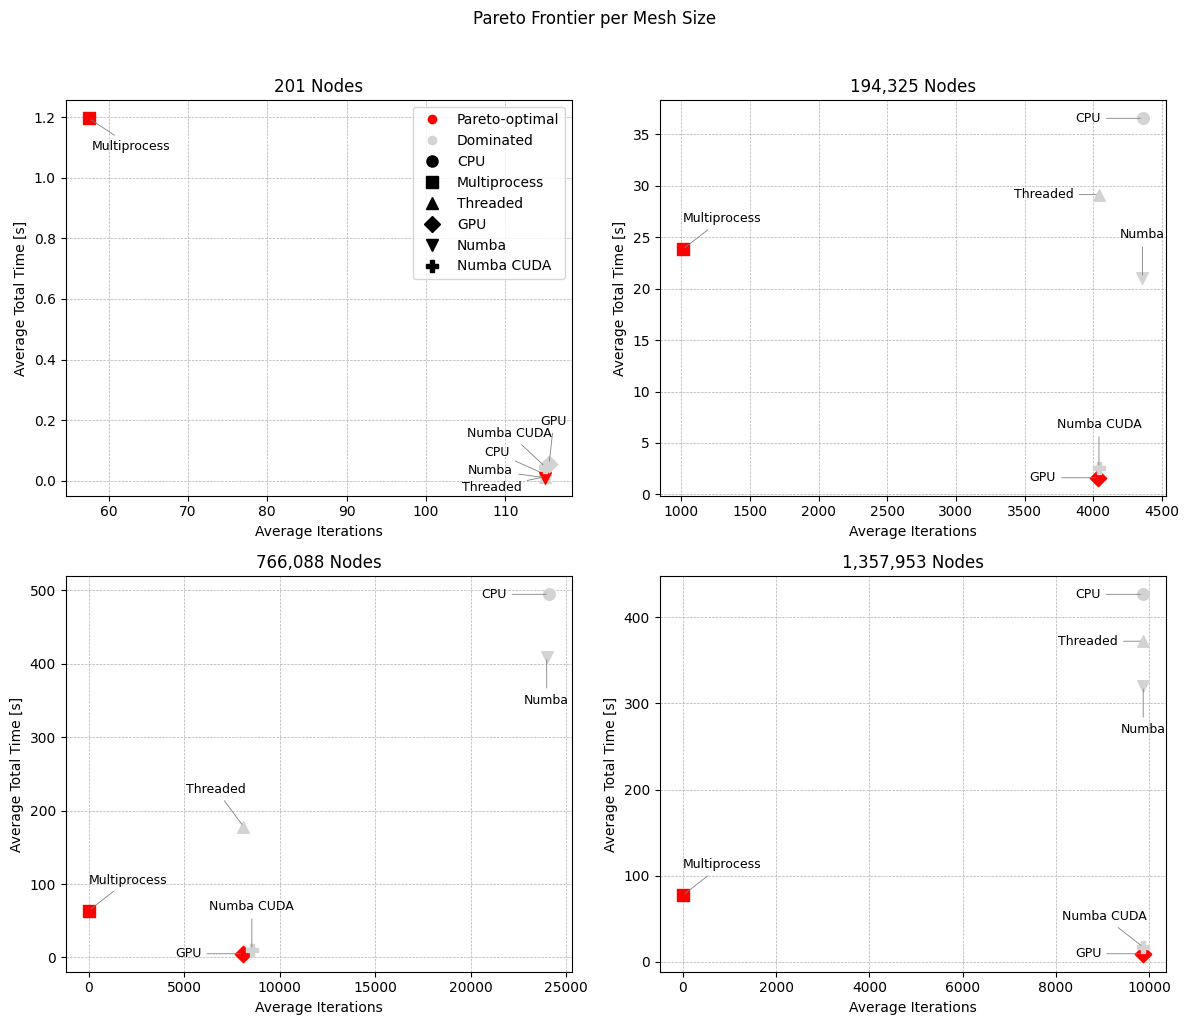

In [247]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# USER CONTROL
# ============================================================

# Label angles PER mesh size (degrees)
LABEL_ANGLES_PER_NODES = {

    # -------------------------------
    # 201 Nodes (top-left)
    # -------------------------------
    201: {
        "Multiprocess": -40,
        "CPU": -210,
        "Threaded": -165,
        "Numba": -190,
        "GPU": 85,
        "Numba CUDA": -230,
    },

    # -------------------------------
    # 194,325 Nodes (top-right)
    # -------------------------------
    194_325: {
        "Multiprocess": 45,
        "CPU": 180,
        "Threaded": 180,
        "Numba": 90,
        "GPU": 180,
        "Numba CUDA": 90,
    },

    # -------------------------------
    # 766,088 Nodes (bottom-left)
    # -------------------------------
    766_088: {
        "Multiprocess": 45,
        "CPU": 180,
        "Threaded": 120,
        "Numba": -90,
        "GPU": 180,
        "Numba CUDA": 90,
    },

    # -------------------------------
    # 1,357,953 Nodes (bottom-right)
    # -------------------------------
    1_357_953: {
        "Multiprocess": 45,
        "CPU": 180,
        "Threaded": 180,
        "Numba": -90,
        "GPU": 180,
        "Numba CUDA": 135,
    },
}


DEFAULT_ANGLE = 0

# Marker per solver
SOLVER_MARKERS = {
    "CPU": "o",
    "Multiprocess": "s",
    "Threaded": "^",
    "GPU": "D",
    "Numba": "v",
    "Numba CUDA": "P",
}
DEFAULT_MARKER = "o"

# ============================================================
# Select representative mesh sizes
# ============================================================

nodes_sorted = sorted(df_all["Nodes"].unique())
idx = np.linspace(0, len(nodes_sorted) - 1, 4, dtype=int)
selected_nodes = [nodes_sorted[i] for i in idx]

# ============================================================
# Pareto utility
# ============================================================

def pareto_mask(x, y):
    mask = np.ones(len(x), dtype=bool)
    for i in range(len(x)):
        for j in range(len(x)):
            if j != i:
                if (x[j] <= x[i] and y[j] <= y[i]) and (x[j] < x[i] or y[j] < y[i]):
                    mask[i] = False
                    break
    return mask

# ============================================================
# Layout
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# ============================================================
# Plot
# ============================================================

for ax, nodes in zip(axes, selected_nodes):

    df_sub = df_all[df_all["Nodes"] == nodes]

    avg_df = (
        df_sub
        .groupby("Solver", as_index=False, observed=True)[
            ["Total Time_s", "Iterations"]
        ]
        .mean()
    )

    is_pareto = pareto_mask(
        avg_df["Iterations"].values,
        avg_df["Total Time_s"].values
    )
    avg_df["Pareto"] = is_pareto

    # Ranges for label displacement
    x_range = avg_df["Iterations"].max() - avg_df["Iterations"].min()
    y_range = avg_df["Total Time_s"].max() - avg_df["Total Time_s"].min()
    rx, ry = 0.12 * x_range, 0.12 * y_range

    # Angle map for this subplot
    angle_map = LABEL_ANGLES_PER_NODES.get(nodes, {})

    # Plot each solver separately (to control markers)
    for _, row in avg_df.iterrows():
        solver = row["Solver"]
        x, y = row["Iterations"], row["Total Time_s"]

        color = "red" if row["Pareto"] else "lightgray"
        marker = SOLVER_MARKERS.get(solver, DEFAULT_MARKER)

        ax.scatter(
            x,
            y,
            color=color,
            marker=marker,
            s=70,
            zorder=3
        )

        # Label placement
        angle_deg = angle_map.get(solver, DEFAULT_ANGLE)
        angle_rad = np.deg2rad(angle_deg)
        dx, dy = rx * np.cos(angle_rad), ry * np.sin(angle_rad)

        ax.annotate(
            solver,
            xy=(x, y),
            xytext=(x + dx, y + dy),
            textcoords="data",
            arrowprops=dict(
                arrowstyle="-",
                linewidth=0.6,
                color="gray"
            ),
            fontsize=9,
            ha="center",
            va="center"
        )

    ax.set_title(f"{nodes:,} Nodes")
    ax.set_xlabel("Average Iterations")
    ax.set_ylabel("Average Total Time [s]")
    ax.grid(True, linestyle="--", linewidth=0.5)

# ============================================================
# Legend (markers + Pareto color meaning)
# ============================================================

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label='Pareto-optimal', markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w',
           label='Dominated', markerfacecolor='lightgray', markersize=8),
]

# Solver marker legend
for solver, marker in SOLVER_MARKERS.items():
    legend_elements.append(
        Line2D([0], [0], marker=marker, color='black',
               label=solver, linestyle='None', markersize=8)
    )

axes[0].legend(handles=legend_elements, loc="best")

fig.suptitle("Pareto Frontier per Mesh Size", y=1.02)
plt.tight_layout()

# ============================================================
# Save
# ============================================================

fig.savefig(
    "pareto_frontier_per_mesh_size_markers_angles.svg",
    bbox_inches="tight",
    dpi=300
)

plt.show()
